# User defined Functions

In [52]:
def hot_code(df):
    #Re-code effective_to_date
    df.loc[df['effective_to_date'].str.contains("1/"),'effective_to_date']="January"
    df.loc[df['effective_to_date'].str.contains("2/"),'effective_to_date']="February"
    return df

def remove_outliers(df,col_list):
    '''Removes outliers from dataframe DF using the 
    IQR * 1.5 rule.  
    Applies only to the columns in list COL_LIST'''
    
    for i in col_list:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        df.drop(df[ (df[i] > upper_bound) | (df[i] < lower_bound) ].index , inplace=True)
        return(df)

#Get independent variable
def create_y(df,y_name):
    y=df[y_name]
    return y

#get dependent variable
def create_x(df,y_name):
    x=df.drop(labels=y_name,axis=1)
    return x

#Create train-test x,ys
def create_train_test_data(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.30,random_state=123)
    return x_train,x_test,y_train,y_test

#Create ColumnTransformer to enable transforming of both numerical & categorical data
def col_transformer(x): 

    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(x)
    categorical_columns = categorical_columns_selector(x)


    categorical_preprocessor = OneHotEncoder(drop='first',handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()


    preprocessor = ColumnTransformer([('cat', categorical_preprocessor, categorical_columns),
                                      ('num', numerical_preprocessor, numerical_columns)],sparse_threshold=0)
    return preprocessor


#Run statmodel OLS
def sm_OLS(x_train_scaled,x_test_scaled,y_train):
    x_train_const_scaled = sm.add_constant(x_train_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    model = sm.OLS(y_train, x_train_const_scaled).fit()
    y_pred_train = model.predict(x_train_const_scaled) 

    x_test_const_scaled = sm.add_constant(x_test_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    y_pred_test = model.predict(x_test_const_scaled) 
    return model,y_pred_train,y_pred_test

#Collect results for analysis
def gather_results(model,y_pred_train,y_train):
    m_mse=mse(y_train,y_pred_train)
    rmse=math.sqrt(mse(y_train,y_pred_train))
    r_mae=mae(y_train,y_pred_train)
    r_squared=model.rsquared
    r_squared_adj=model.rsquared_adj
    df_data={'MSE':[round(m_mse,2)],'RMSE':[round(rmse,3)],'R-Squared':[round(r_squared,3)],'R-Squared-Adj':[round(r_squared_adj,3)]}
    temp_df=pd.DataFrame(df_data)
    return temp_df

# Day 1 Import everything

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
import qgrid
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
import math


In [54]:
df=pd.read_csv(r'C:\Users\MichaelTaylo_c9zoof3\Documents\GitHub\IH_Berliners\Data\5. Updated with continent codes\nutrition_demographic_covid_continent_multicoll_b.csv')

In [55]:

qgrid.show_grid(df,grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Check multicollinearity

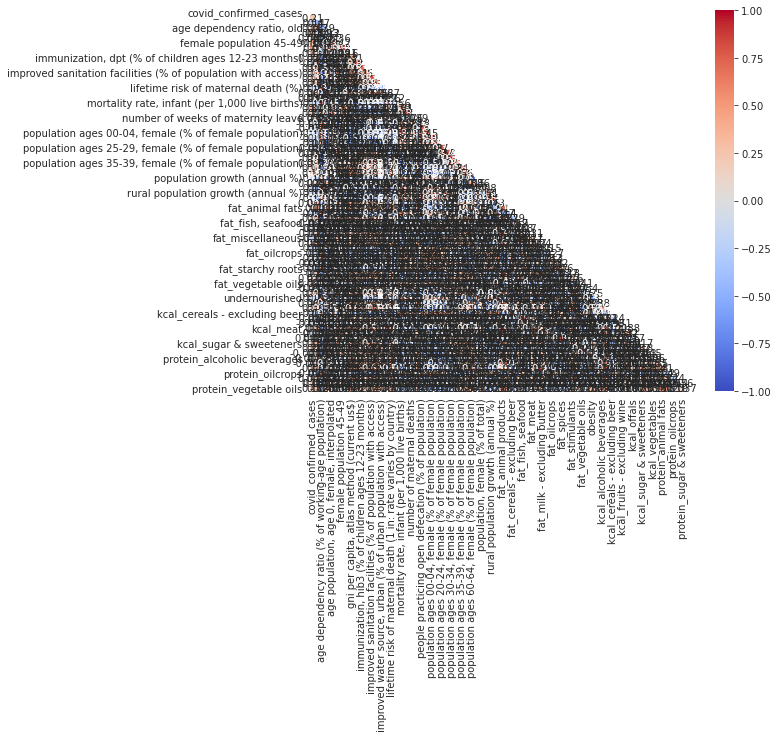

In [56]:
#check if there are highly correlated features and drop them if there are any.
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Review numerical data

In [57]:
#get numericals
numericals=df._get_numeric_data()
numericals


,covid_confirmed_cases,covid_fatality_rate,age dependency ratio (% of working-age population),"age dependency ratio, old","age population, age 0, female, interpolated",diabetes prevalence (% of population ages 20 to 79),female population 45-49,female population 80+,"gni per capita, atlas method (current us$)","immunization, dpt (% of children ages 12-23 months)",...,kcal_sugar & sweeteners,kcal_vegetable oils,kcal_vegetables,protein_alcoholic beverages,protein_animal fats,protein_milk - excluding butter,protein_oilcrops,protein_stimulants,protein_sugar & sweeteners,protein_vegetable oils
0,158084,0.000226,86.954464,4.616073,470554.0,8.8,496113.0,43481.0,630.0000,78.000000,...,2.2261,2.3012,0.7504,0.0000,0.0277,5.5278,0.2034,0.5546,0.0000,0.0000
1,210224,0.001113,44.806973,17.950766,21438.0,10.3,97198.0,41381.0,4290.0000,98.000000,...,3.4422,2.8244,2.7508,0.1840,0.0711,16.4750,0.3722,0.2635,0.0042,0.0084
2,218432,0.000158,52.617579,9.062490,459353.0,7.5,1053861.0,253907.0,4870.0000,95.000000,...,3.9869,5.7638,2.0457,0.0323,0.0054,8.0616,0.1830,0.4628,0.0000,0.0269
3,81593,0.000071,99.855751,4.623604,502641.0,4.1,383280.0,38663.0,4180.0000,64.000000,...,2.7539,4.2741,0.3525,0.6285,0.0277,1.1460,2.1534,0.1017,0.0092,0.0092
4,4283,0.001296,45.650381,10.434645,734.0,13.6,4400.0,947.0,13390.0000,99.000000,...,5.8218,4.6904,1.2960,0.1535,0.1289,7.4349,0.7674,0.4113,0.0000,0.0430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,10126,0.000074,75.595147,4.893864,392662.0,5.1,409910.0,43605.0,13410.2027,69.000000,...,7.0303,3.9515,0.3636,0.0000,0.0188,1.9630,0.2254,0.3193,0.0000,0.0000
158,254274,0.000230,95.402326,5.683539,295178.0,4.1,216644.0,38313.0,1500.0000,90.000000,...,2.5590,3.0062,0.4472,0.4824,0.0338,1.0324,8.0562,0.0762,0.0000,0.0000
159,213258,0.000321,80.391033,5.347744,262428.0,3.9,194583.0,48432.0,850.0000,87.000000,...,5.0403,6.2601,0.2532,0.2929,0.0391,2.4114,1.5230,0.2636,0.0000,0.0293
160,63515,0.001147,47.920177,15.042344,1990.0,19.6,9292.0,3091.0,13410.2027,88.708075,...,4.2720,6.4716,0.9998,0.3262,0.1873,7.2857,1.2143,0.4591,0.0000,0.0362


C:\Users\MichaelTaylo_c9zoof3\AppData\Local\Temp\ipykernel_19564\3414007053.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9,5))


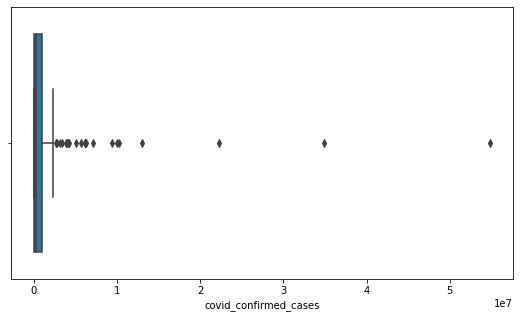

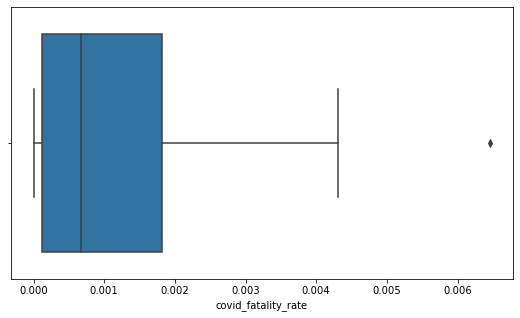

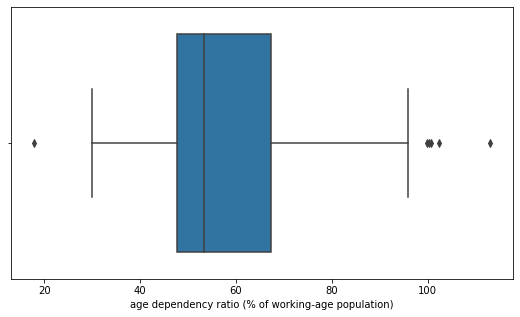

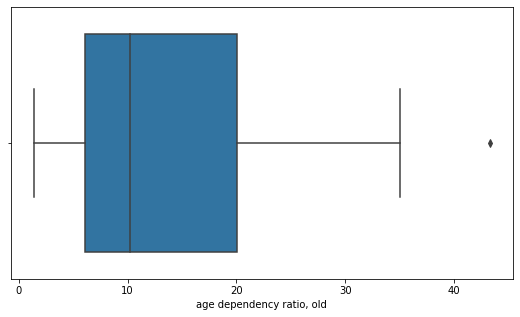

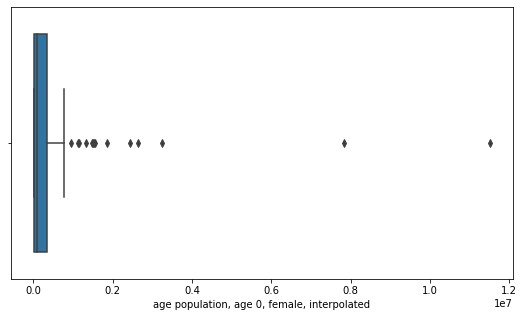

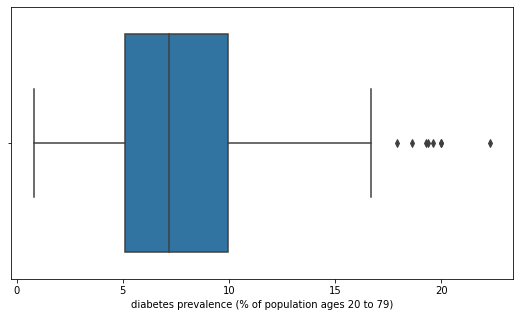

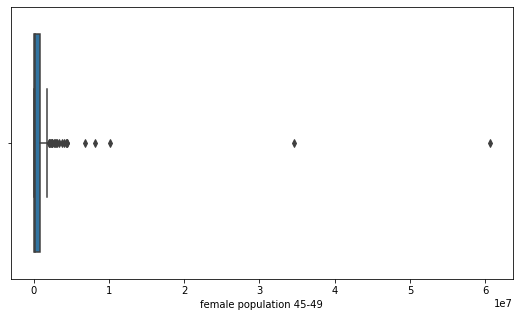

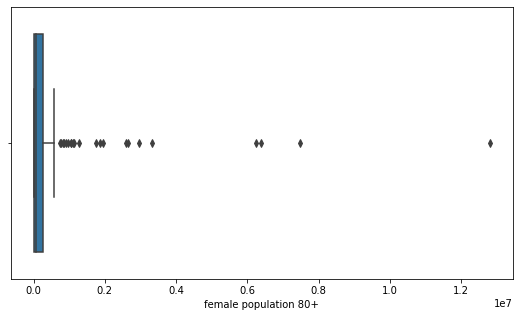

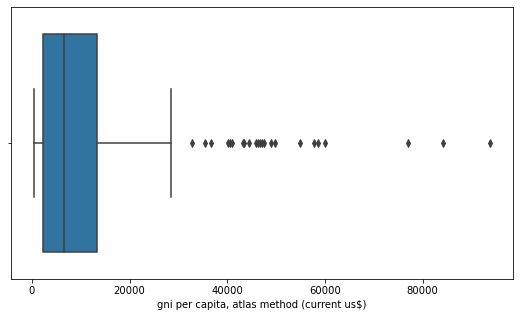

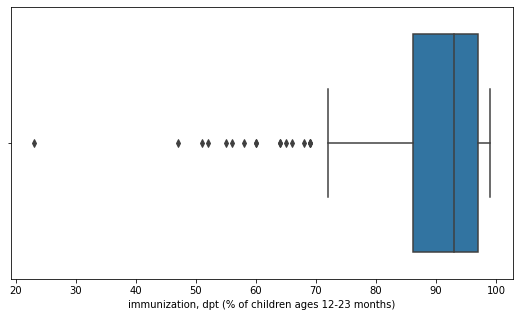

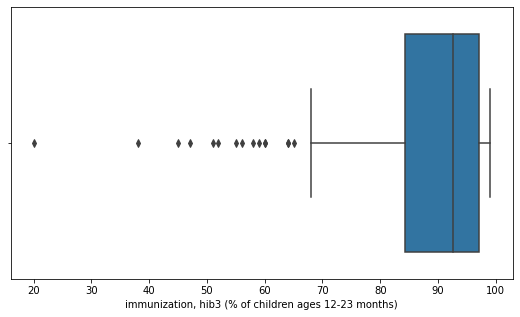

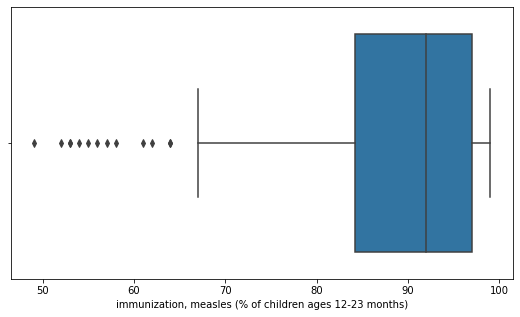

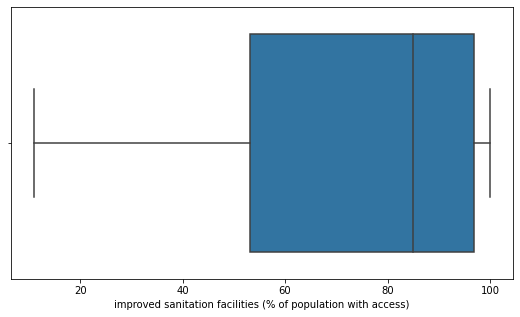

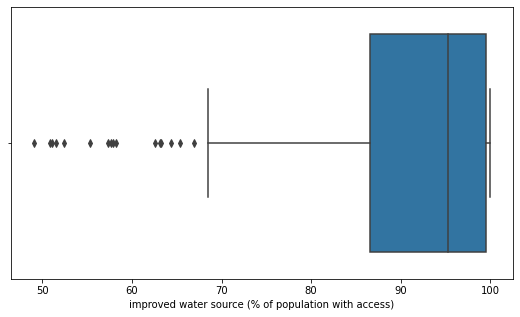

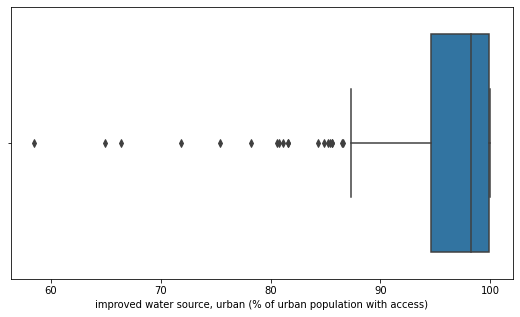

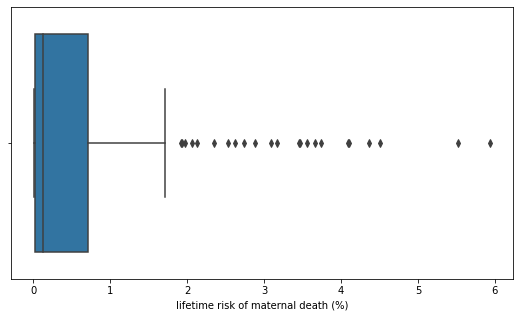

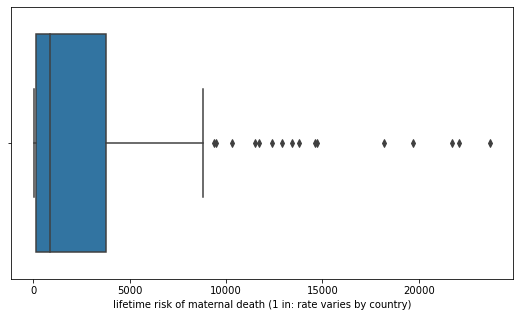

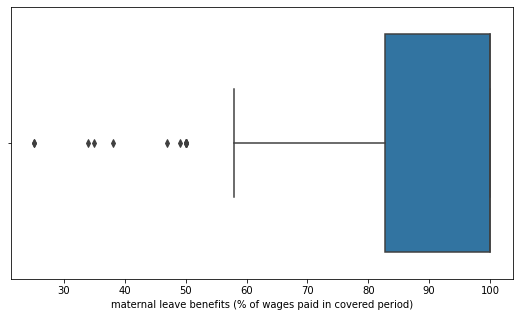

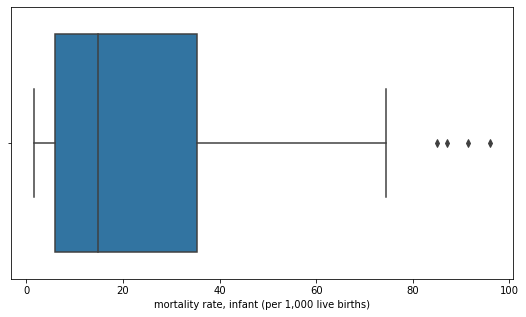

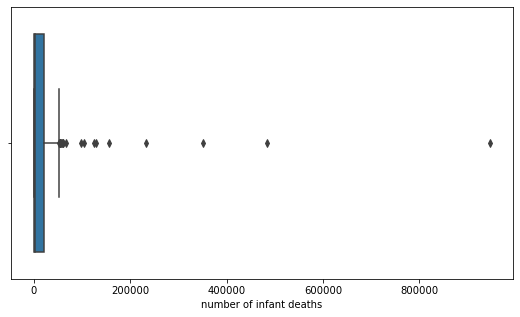

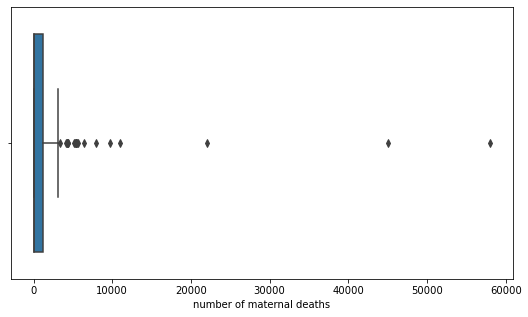

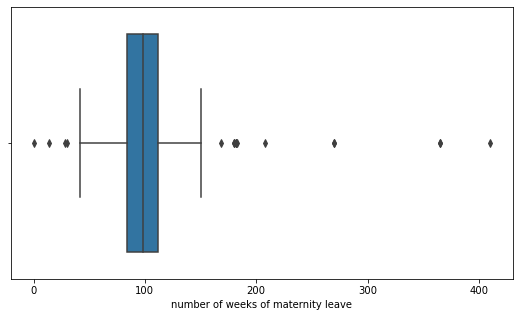

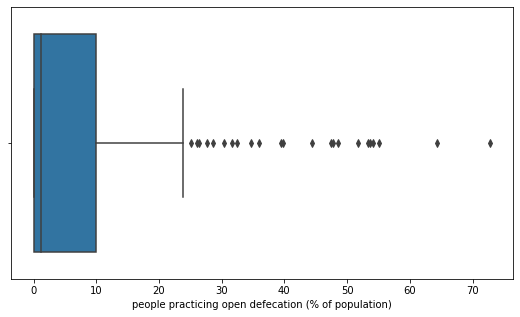

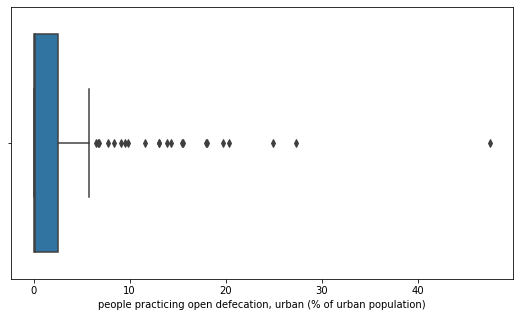

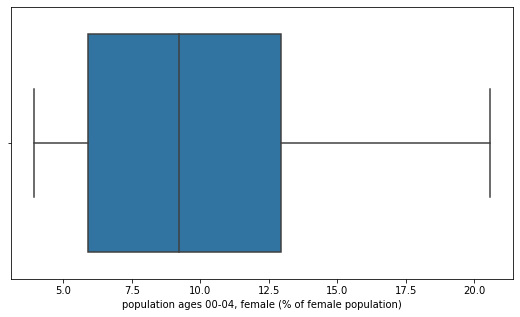

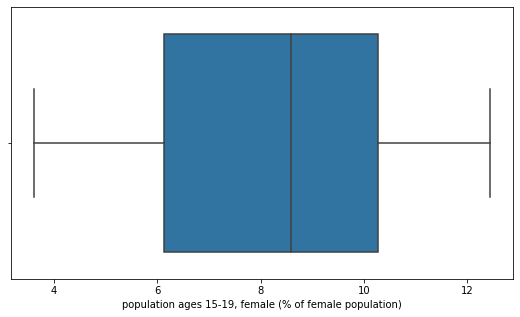

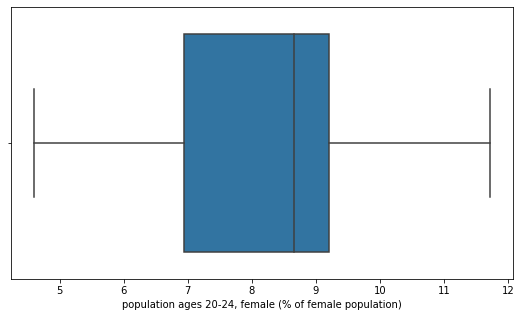

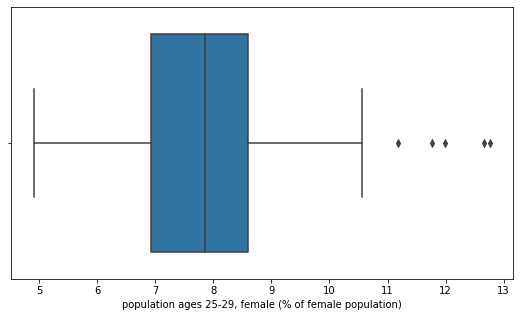

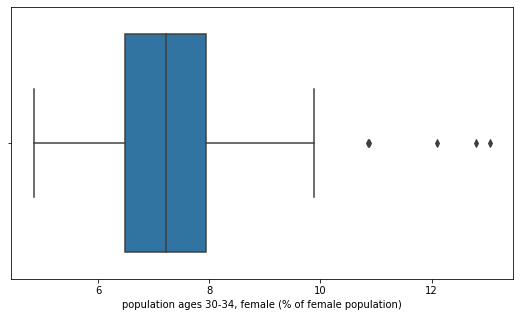

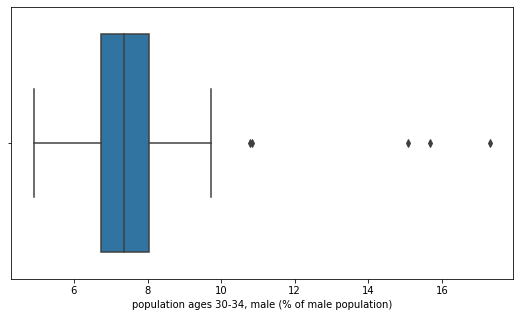

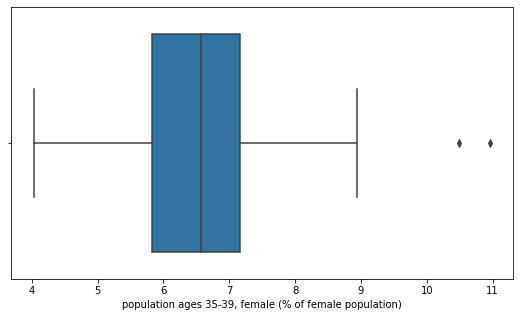

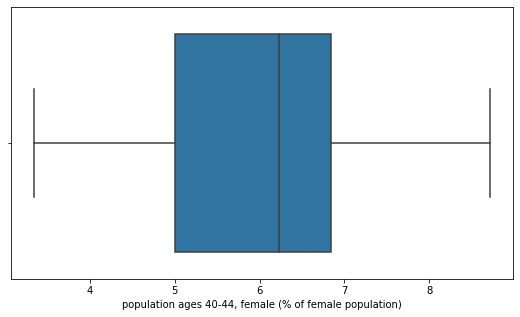

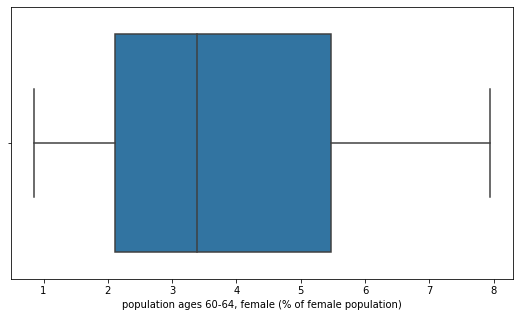

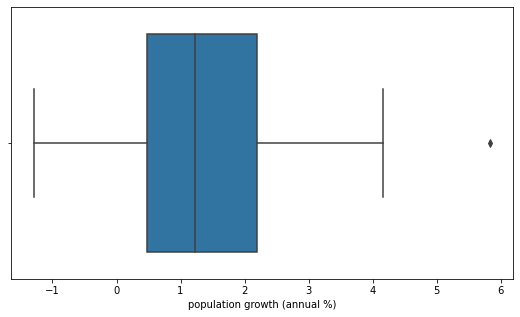

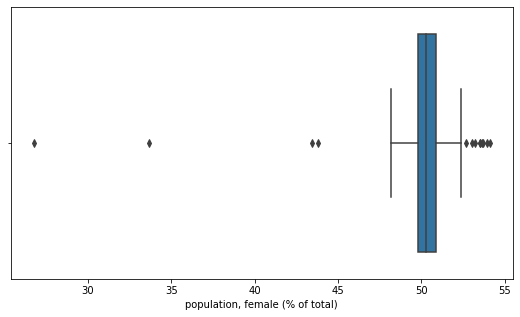

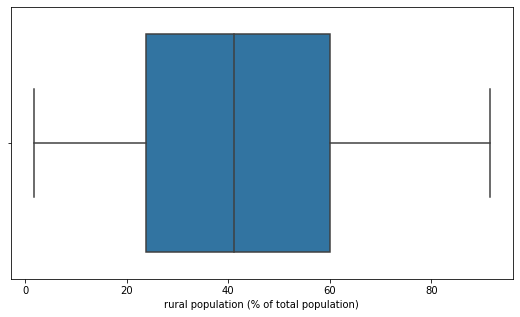

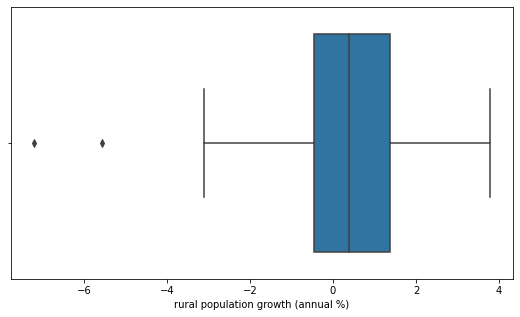

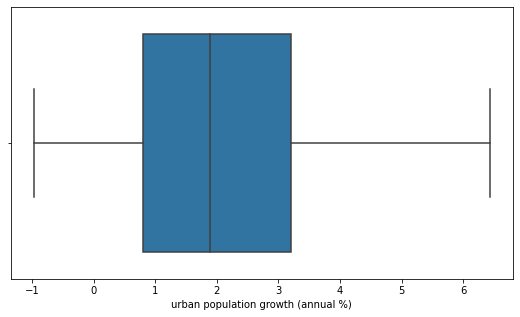

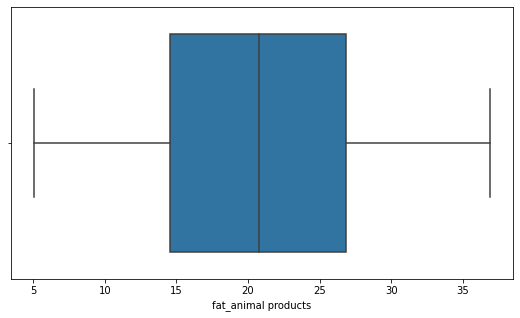

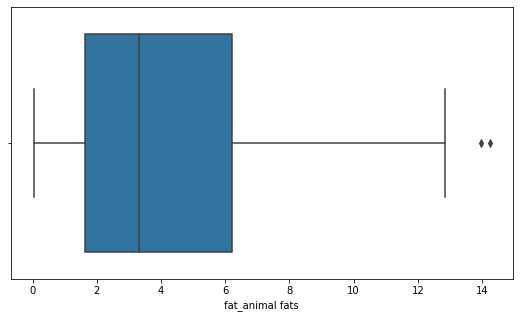

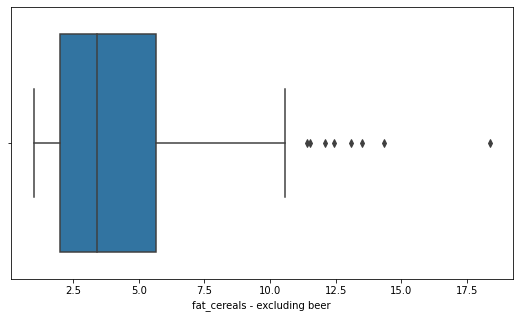

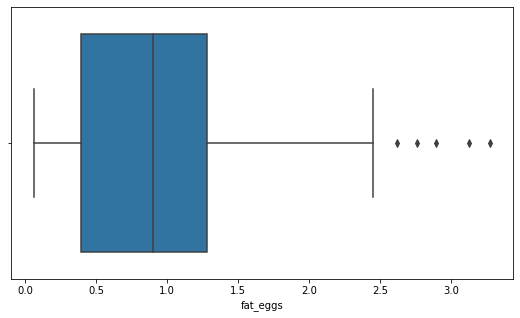

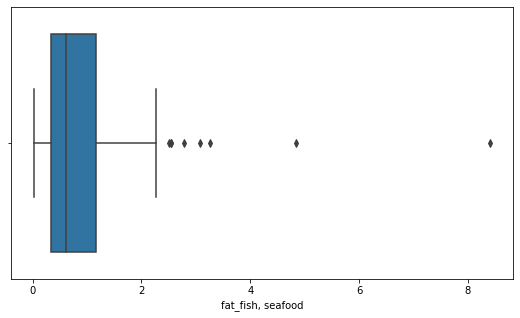

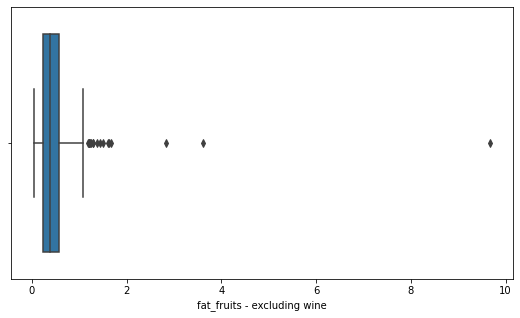

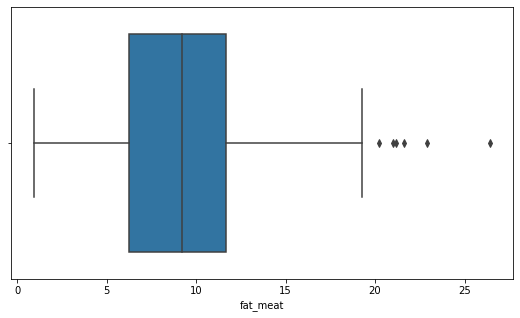

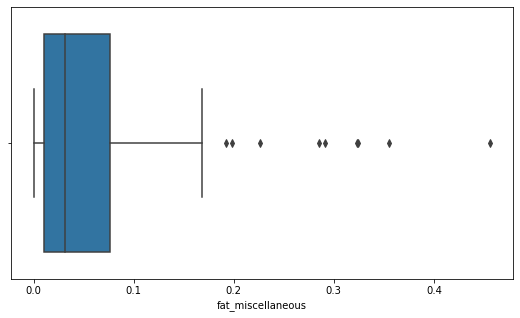

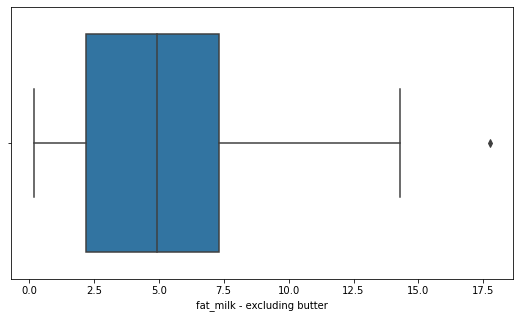

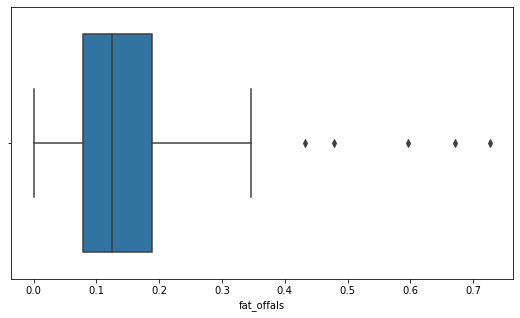

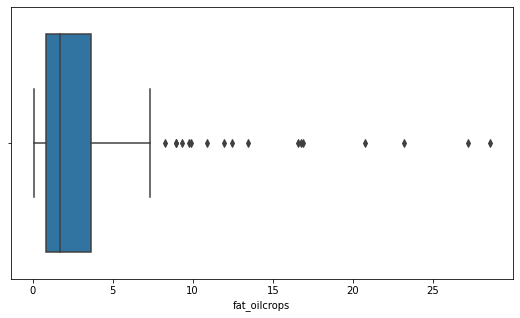

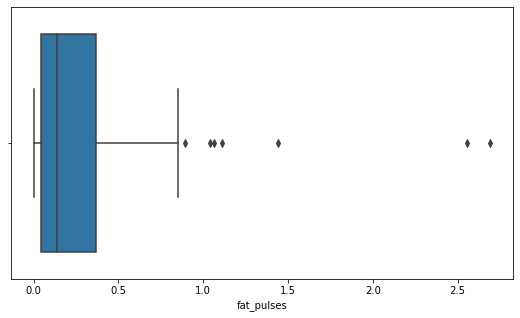

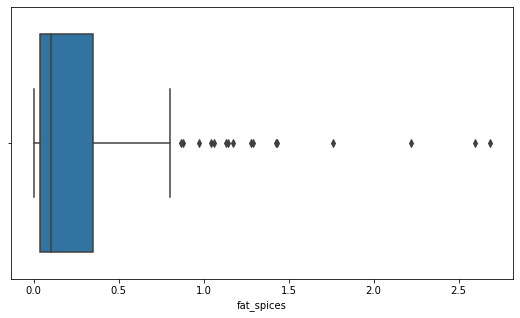

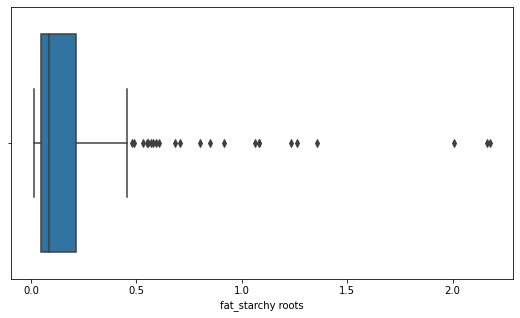

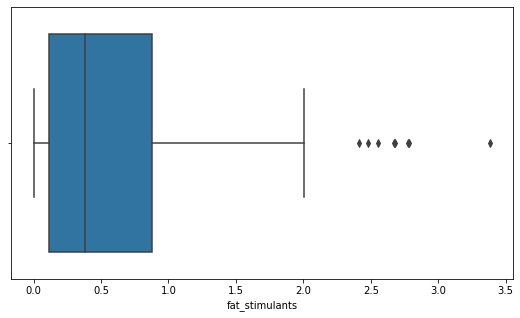

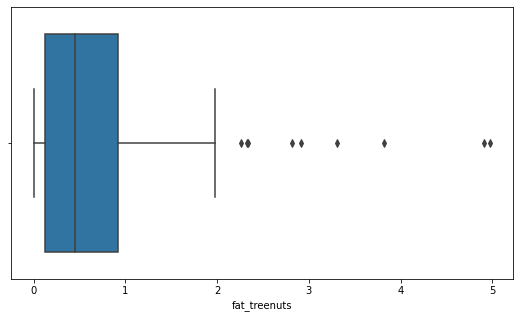

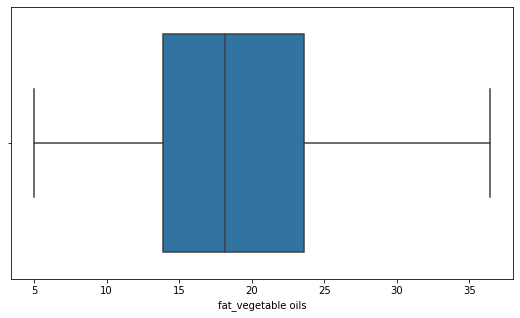

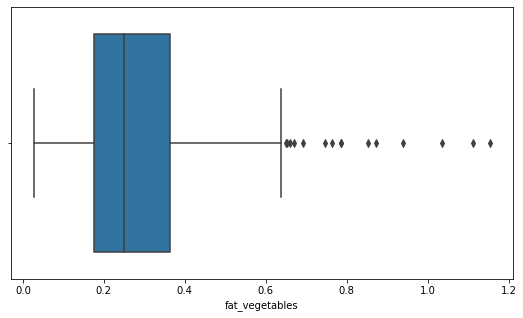

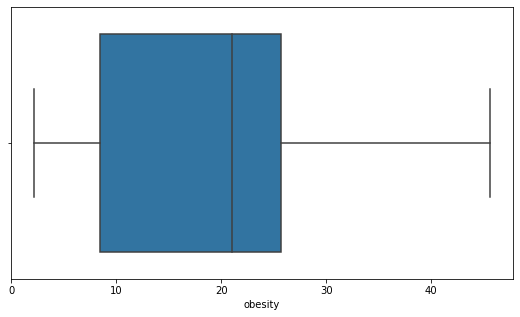

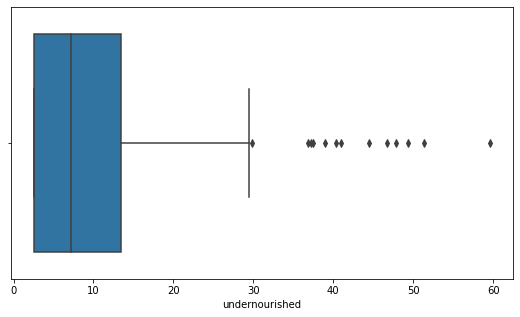

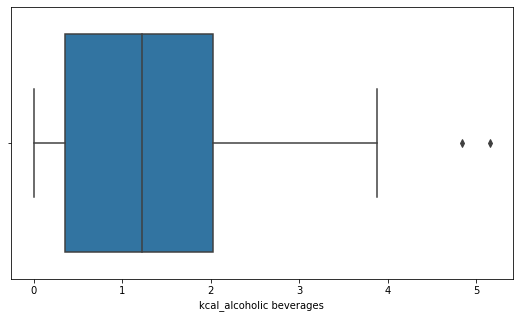

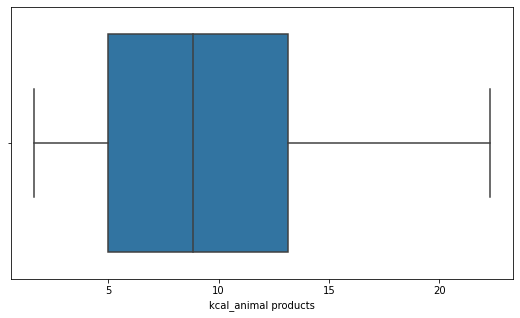

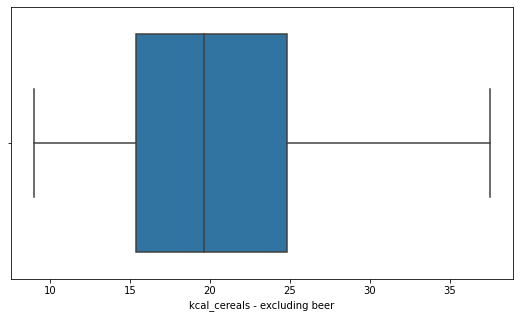

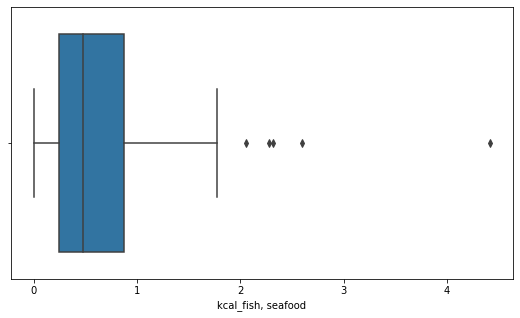

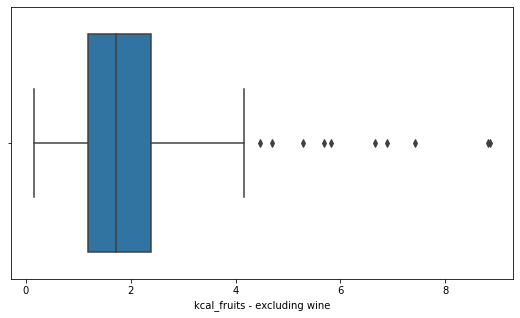

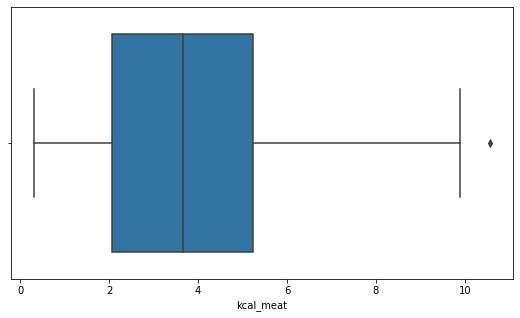

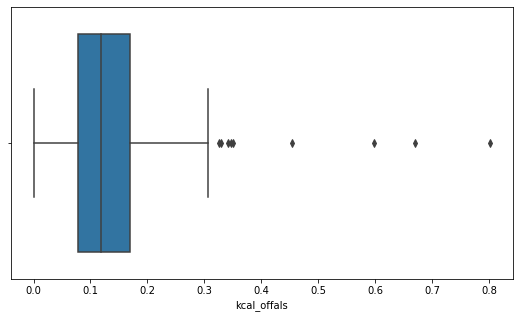

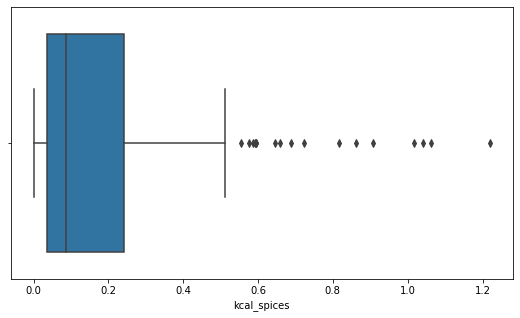

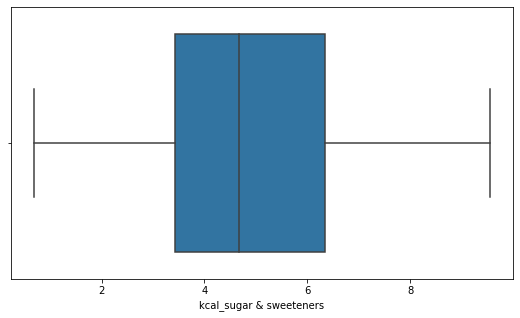

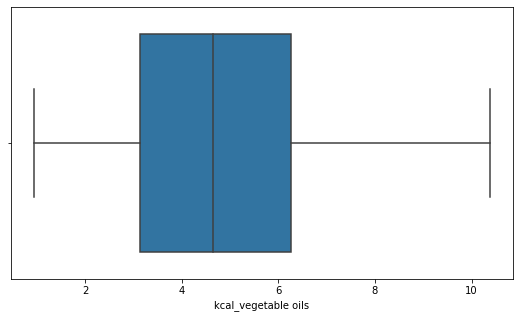

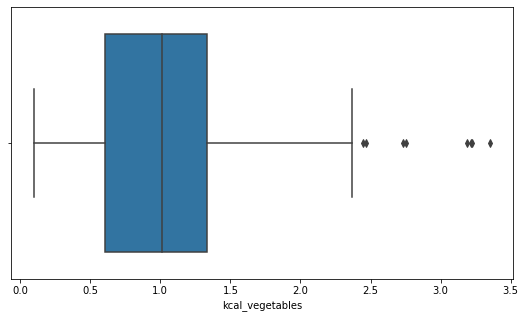

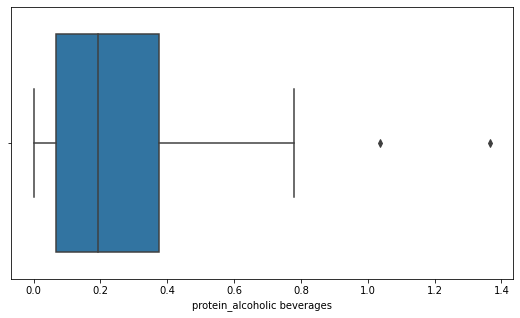

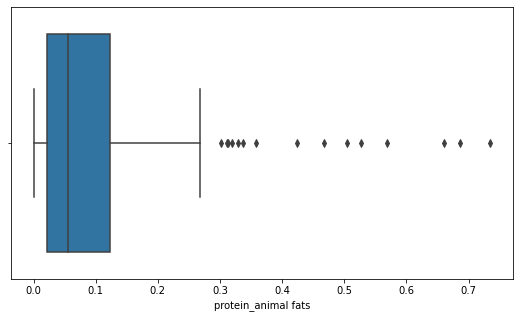

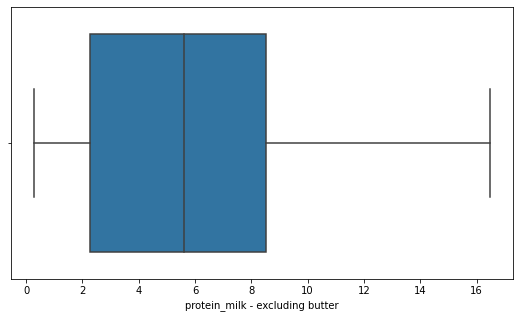

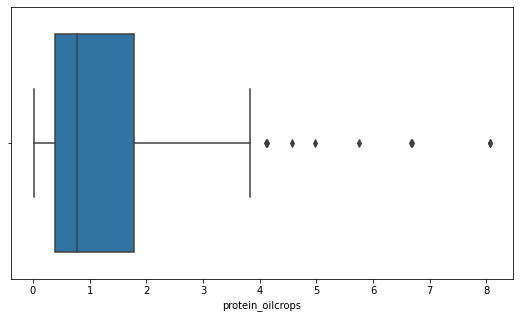

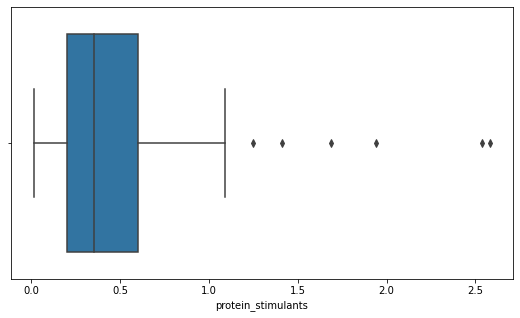

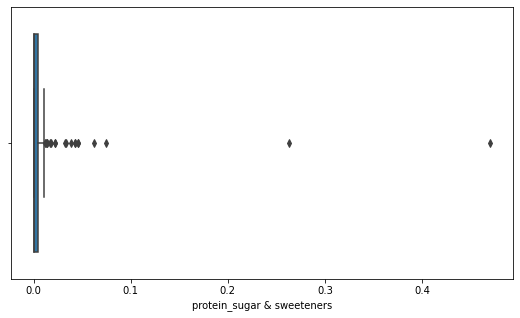

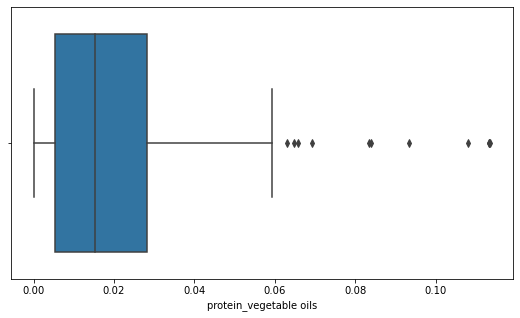

In [58]:
x=numericals.columns
for i in x:
    plt.figure(figsize=(9,5))
    sns.boxplot(x=i,data=numericals) 

array([[<AxesSubplot:title={'center':'covid_confirmed_cases'}>,
        <AxesSubplot:title={'center':'covid_fatality_rate'}>,
        <AxesSubplot:title={'center':'age dependency ratio (% of working-age population)'}>,
        <AxesSubplot:title={'center':'age dependency ratio, old'}>,
        <AxesSubplot:title={'center':'age population, age 0, female, interpolated'}>,
        <AxesSubplot:title={'center':'diabetes prevalence (% of population ages 20 to 79)'}>,
        <AxesSubplot:title={'center':'female population 45-49'}>,
        <AxesSubplot:title={'center':'female population 80+'}>,
        <AxesSubplot:title={'center':'gni per capita, atlas method (current us$)'}>],
       [<AxesSubplot:title={'center':'immunization, dpt (% of children ages 12-23 months)'}>,
        <AxesSubplot:title={'center':'immunization, hib3 (% of children ages 12-23 months)'}>,
        <AxesSubplot:title={'center':'immunization, measles (% of children ages 12-23 months)'}>,
        <AxesSubplot:title={'c

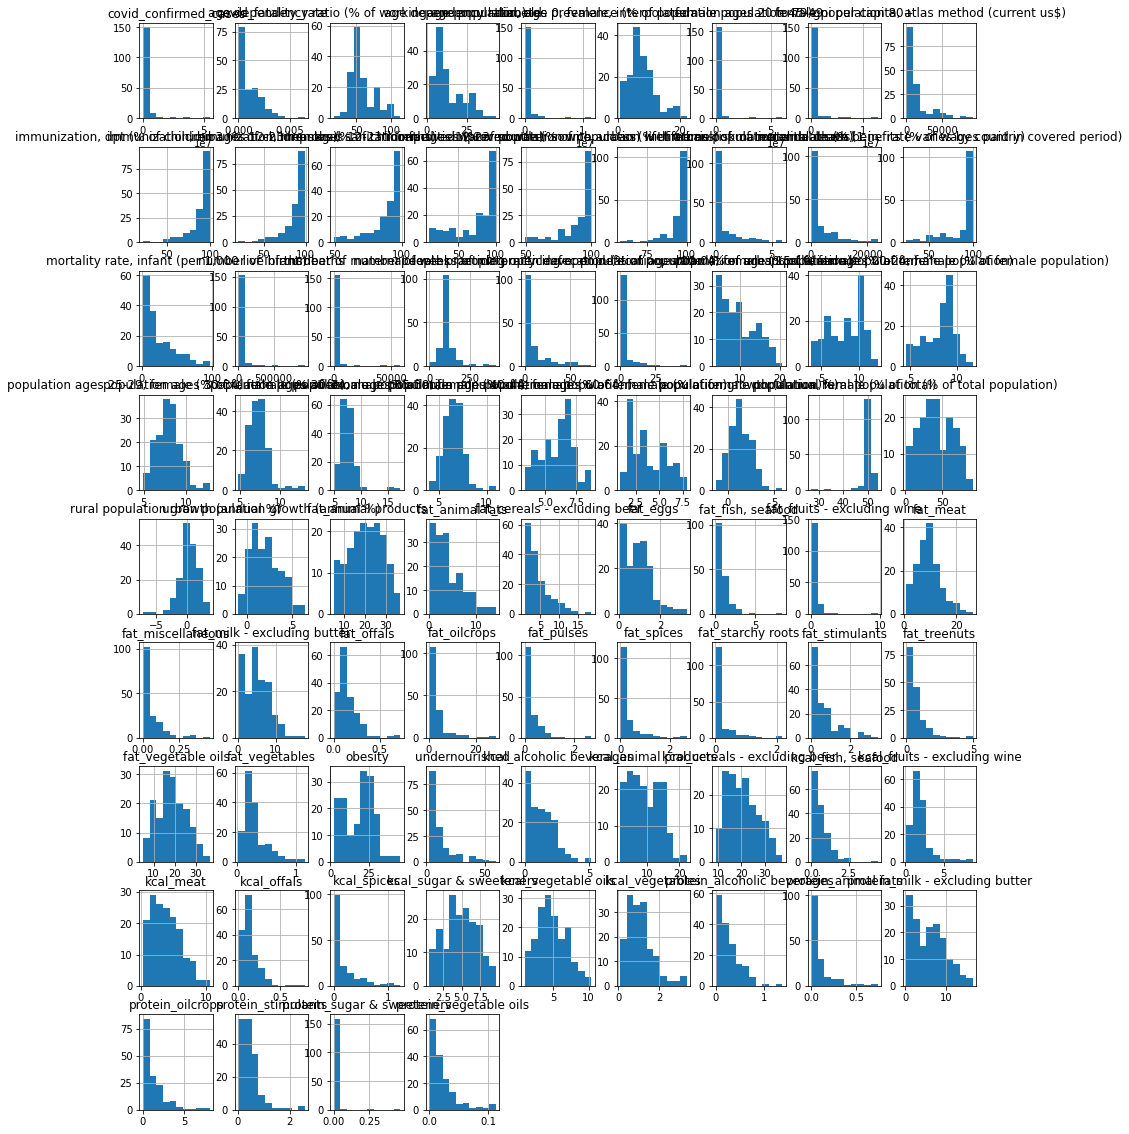

In [59]:
numericals.hist(figsize=(15,20))

# Code used per project

In [60]:
#Which dataframe did I use?

#df_used = numericals.copy()        #numbers only
df_used = numericals.copy()                #numbers + categorical

## Remove outliers

In [61]:
#Remove outliers
outlier_list=numericals.columns
remove_outliers(df_used,outlier_list)

,covid_confirmed_cases,covid_fatality_rate,age dependency ratio (% of working-age population),"age dependency ratio, old","age population, age 0, female, interpolated",diabetes prevalence (% of population ages 20 to 79),female population 45-49,female population 80+,"gni per capita, atlas method (current us$)","immunization, dpt (% of children ages 12-23 months)",...,kcal_sugar & sweeteners,kcal_vegetable oils,kcal_vegetables,protein_alcoholic beverages,protein_animal fats,protein_milk - excluding butter,protein_oilcrops,protein_stimulants,protein_sugar & sweeteners,protein_vegetable oils
0,158084,0.000226,86.954464,4.616073,470554.0,8.8,496113.0,43481.0,630.0000,78.000000,...,2.2261,2.3012,0.7504,0.0000,0.0277,5.5278,0.2034,0.5546,0.0000,0.0000
1,210224,0.001113,44.806973,17.950766,21438.0,10.3,97198.0,41381.0,4290.0000,98.000000,...,3.4422,2.8244,2.7508,0.1840,0.0711,16.4750,0.3722,0.2635,0.0042,0.0084
2,218432,0.000158,52.617579,9.062490,459353.0,7.5,1053861.0,253907.0,4870.0000,95.000000,...,3.9869,5.7638,2.0457,0.0323,0.0054,8.0616,0.1830,0.4628,0.0000,0.0269
3,81593,0.000071,99.855751,4.623604,502641.0,4.1,383280.0,38663.0,4180.0000,64.000000,...,2.7539,4.2741,0.3525,0.6285,0.0277,1.1460,2.1534,0.1017,0.0092,0.0092
4,4283,0.001296,45.650381,10.434645,734.0,13.6,4400.0,947.0,13390.0000,99.000000,...,5.8218,4.6904,1.2960,0.1535,0.1289,7.4349,0.7674,0.4113,0.0000,0.0430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,10126,0.000074,75.595147,4.893864,392662.0,5.1,409910.0,43605.0,13410.2027,69.000000,...,7.0303,3.9515,0.3636,0.0000,0.0188,1.9630,0.2254,0.3193,0.0000,0.0000
158,254274,0.000230,95.402326,5.683539,295178.0,4.1,216644.0,38313.0,1500.0000,90.000000,...,2.5590,3.0062,0.4472,0.4824,0.0338,1.0324,8.0562,0.0762,0.0000,0.0000
159,213258,0.000321,80.391033,5.347744,262428.0,3.9,194583.0,48432.0,850.0000,87.000000,...,5.0403,6.2601,0.2532,0.2929,0.0391,2.4114,1.5230,0.2636,0.0000,0.0293
160,63515,0.001147,47.920177,15.042344,1990.0,19.6,9292.0,3091.0,13410.2027,88.708075,...,4.2720,6.4716,0.9998,0.3262,0.1873,7.2857,1.2143,0.4591,0.0000,0.0362


## Start x-y split

In [62]:
#Prep X-Y Split
y_name='covid_fatality_rate'
y=create_y(df_used,y_name)
x=create_x(df_used,y_name)

#Create train-test data
x_train,x_test,y_train,y_test=create_train_test_data(x,y)

#Create transformer to normalize data
transformer=col_transformer(x_train)

#Normalize/scale data
x_train_scaled=transformer.fit_transform(x_train)
x_test_scaled=transformer.transform(x_test)

feature_names=transformer.get_feature_names_out()
x_train_scaled=pd.DataFrame(data=x_train_scaled,columns=feature_names)
x_test_scaled=pd.DataFrame(data=x_test_scaled,columns=feature_names)

#Create OLS model using statsmodel
y_train=y_train.values.reshape(-1,1)
model,y_pred_train,y_pred_test=sm_OLS(x_train_scaled,x_test_scaled,y_train)

#Gather results of the OLS
#y_pred_test=y_pred_test.values.reshape(-1,1)
results_model=gather_results(model,y_pred_train,y_train)
results_model


,MSE,RMSE,R-Squared,R-Squared-Adj
0,0.0,0.0,0.895,0.539


In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     2.513
Date:                Tue, 28 Jun 2022   Prob (F-statistic):            0.00868
Time:                        14:46:16   Log-Likelihood:                 654.49
No. Observations:                  98   AIC:                            -1157.
Df Residuals:                      22   BIC:                            -960.5
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
const                                                                     0.0008   6.49e-05     12.040      0.000       0.001       0.001
num__covid_confirmed_cases                                                0.0003      0.000      1.627      0.118   -7.41e-05       0.001
num__age dependency ratio (% of working-age population)                  -0.0006      0.001     -0.485      0.632      -0.003       0.002
num__age dependency ratio, old                                            0.0006      0.001      0.545      0.592      -0.002       0.003
num__age population, age 0, female, interpolated                         -0.0002      0.001     -0.207      0.838      -0.003       0.002
num__diabetes prevalence (% of population ages 20 to 79)              -4.151e-05      0.000     -0.188      0.852      -0.000       0.000
num__female population 45-49                                             -0.0002      0.001     -0.295      0.771      -0.002       0.001
num__female population 80+                                                0.0003      0.000      0.852      0.403      -0.000       0.001
num__gni per capita, atlas method (current us$)                          -0.0006      0.000     -3.055      0.006      -0.001      -0.000
num__immunization, dpt (% of children ages 12-23 months)               7.235e-05      0.000      0.182      0.858      -0.001       0.001
num__immunization, hib3 (% of children ages 12-23 months)                -0.0002      0.000     -0.422      0.677      -0.001       0.001
num__immunization, measles (% of children ages 12-23 months)             -0.0002      0.000     -0.711      0.485      -0.001       0.000
num__improved sanitation facilities (% of population with access)         0.0005      0.000      1.544      0.137      -0.000       0.001
num__improved water source (% of population with access)                 -0.0001      0.000     -0.383      0.705      -0.001       0.001
num__improved water source, urban (% of urban population with access)     0.0003      0.000      1.282      0.213      -0.000       0.001
num__lifetime risk of maternal death (%)                                 -0.0003      0.000     -0.714      0.483      -0.001       0.000
num__lifetime risk of maternal death (1 in: rate varies by country)      -0.0004      0.000     -1.703      0.103      -0.001     9.5e-05
num__maternal leave benefits (% of wages paid in covered period)          0.0001      0.000      0.860      0.399      -0.000       0.000
num__mortality rate, infant (per 1,000 live births)                       0.0004      0.000      0.830      0.415      -0.001       0.001
num__number of infant deaths                   

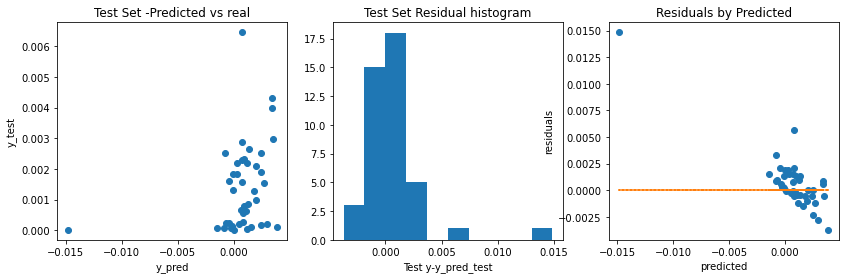

In [76]:
# Make an scatter plot y_pred vs y. Should be close to a straight line
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred_test, y_test, 'o')
ax[0].set_xlabel("y_pred")
ax[0].set_ylabel("y_test")
ax[0].set_title("Test Set -Predicted vs real")
# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
y_test.reset_index(drop=True,inplace=True)
ax[1].hist(y_test - y_pred_test)
ax[1].set_xlabel("Test y-y_pred_test")
ax[1].set_title("Test Set Residual histogram")
ax[2].plot(y_pred_test,y_test - y_pred_test,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')


<AxesSubplot:xlabel='y_pred_test', ylabel='y_test'>

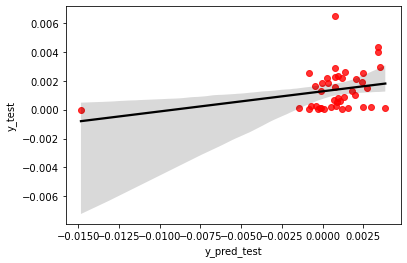

In [65]:
result=pd.DataFrame({"y_test":y_test,"y_pred_test":y_pred_test})

sns.regplot(x='y_pred_test',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

## Coefficients in importance order with p-values

In [46]:
def top_features():
    features_importance = pd.DataFrame(data={
    'Importance': abs(model.params[1:]),
    'Coefficient': model.params[1:], 'P-value': round(model.pvalues[1:],4)})
    features_importance = features_importance.sort_values(by='Importance', ascending=False)
    return features_importance

features_importance=top_features()
qgrid.show_grid(features_importance,grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

# Manual version of stepwise backward elimination

In [47]:
keep_going=True

while keep_going==True:
   #Prep X-Y Split
    y_name='covid_fatality_rate'
    y=create_y(df_used,y_name)
    x=create_x(df_used,y_name)

    #Create train-test data
    x_train,x_test,y_train,y_test=create_train_test_data(x,y)

    #Create transformer to normalize data
    transformer=col_transformer(x_train)

    #Normalize/scale data
    x_train_scaled=transformer.fit_transform(x_train)
    x_test_scaled=transformer.transform(x_test)
    feature_names=transformer.get_feature_names_out()
    x_train_scaled=pd.DataFrame(data=x_train_scaled,columns=feature_names)
    x_test_scaled=pd.DataFrame(data=x_test_scaled,columns=feature_names)

    #Create OLS model using statsmodel
    y_train=y_train.values.reshape(-1,1)
    model,y_pred_train,y_pred_test=sm_OLS(x_train_scaled,x_test_scaled,y_train)

    #Gather results of the OLS
    #y_pred_test=y_pred_test.values.reshape(-1,1)
    results_model=gather_results(model,y_pred_train,y_train)
    print(results_model)
    
    #remove stepwise feature.  if done is written, stop removing
    features_importance=top_features()
    temp_features=features_importance.sort_values(by='P-value', ascending=False)
    worst_feature=temp_features.iloc[0,:]
    print(worst_feature)
    worst_feature=str(worst_feature.name)
    drop_value=input("Drop column?")
    if drop_value=="done":
        keep_going=False
    else:
        stp=r'num_'
        worst_feature=worst_feature.strip('num').strip('_')
        df_used.drop(labels=worst_feature,axis=1,inplace=True)
        df_used.columns

   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.895          0.539
Importance     0.000018
Coefficient   -0.000018
P-value        0.960200
Name: num__people practicing open defecation (% of population), dtype: float64
Drop column?y
   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.895          0.559
Importance     0.000033
Coefficient   -0.000033
P-value        0.957600
Name: num__population ages 30-34, male (% of male population), dtype: float64
Drop column?
   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.895          0.577
Importance     0.00001
Coefficient    0.00001
P-value        0.96320
Name: num__obesity, dtype: float64
Drop column?
   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.895          0.594
Importance     0.000068
Coefficient    0.000068
P-value        0.895200
Name: num__kcal_spices, dtype: float64
Drop column?
   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.895           0.61
Importance     0.000042
Coefficient    0.

Drop column?
   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.852          0.757
Importance     0.000327
Coefficient    0.000327
P-value        0.092200
Name: num__fat_miscellaneous, dtype: float64
Drop column?
   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.845          0.749
Importance     0.000358
Coefficient    0.000358
P-value        0.344500
Name: num__fat_starchy roots, dtype: float64
Drop column?
   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.842          0.749
Importance     0.000867
Coefficient    0.000867
P-value        0.428200
Name: num__fat_oilcrops, dtype: float64
Drop column?
   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.841          0.751
Importance     0.000037
Coefficient    0.000037
P-value        0.605600
Name: num__fat_spices, dtype: float64
Drop column?
   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0       0.84          0.754
Importance     0.000093
Coefficient    0.000093
P-value        0.166300
Name: num__fat_tr

In [48]:
def top_features():
    features_importance = pd.DataFrame(data={
    'Importance': abs(model.params[1:]),
    'Coefficient': model.params[1:], 'P-value': round(model.pvalues[1:],4)})
    features_importance = features_importance.sort_values(by='Importance', ascending=False)
    return features_importance

features_importance=top_features()
qgrid.show_grid(features_importance,grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     19.02
Date:                Tue, 28 Jun 2022   Prob (F-statistic):           3.24e-17
Time:                        14:43:59   Log-Likelihood:                 596.75
No. Observations:                  98   AIC:                            -1174.
Df Residuals:                      88   BIC:                            -1148.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                           0.0008   5.85e-05     13.360      0.000       0.001       0.001
num__covid_confirmed_cases                                      0.0002   7.67e-05      3.040      0.003    8.07e-05       0.000
num__age population, age 0, female, interpolated               -0.0004      0.000     -3.140      0.002      -0.001      -0.000
num__gni per capita, atlas method (current us$)                -0.0004   7.17e-05     -6.095      0.000      -0.001      -0.000
num__number of maternal deaths                                  0.0003      0.000      2.560      0.012    6.54e-05       0.001
num__population ages 00-04, female (% of female population)    -0.0004      0.000     -3.359      0.001      -0.001      -0.000
num__rural population growth (annual %)                         0.0002   7.85e-05      2.478      0.015    3.85e-05       0.000
num__fat_milk - excluding butter                               -0.0003      0.000     -2.188      0.031      -0.001    -2.9e-05
num__fat_stimulants                                             0.0003   7.46e-05      3.807      0.000       0.000       0.000
num__protein_milk - excluding butter                            0.0006      0.000      3.954      0.000       0.000       0.001
==============================================================================
Omnibus:                        6.133   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.501
Skew:                           0.528   Prob(JB):                       0.0639
Kurtosis:                       3.483   Cond. No.                         7.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

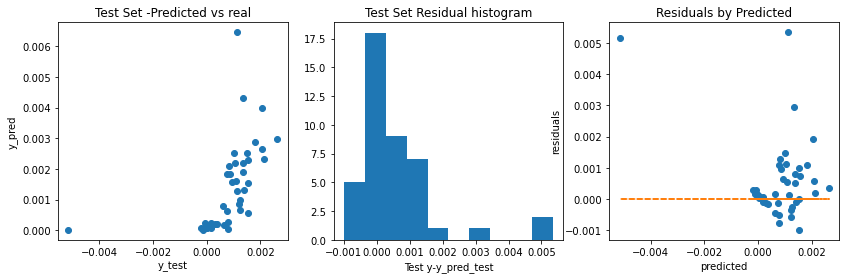

In [50]:
# Make an scatter plot y_pred vs y. Should be close to a straight line
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred_test, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")
# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
y_test.reset_index(drop=True,inplace=True)
ax[1].hist(y_test - y_pred_test)
ax[1].set_xlabel("Test y-y_pred_test")
ax[1].set_title("Test Set Residual histogram")
ax[2].plot(y_pred_test,y_test - y_pred_test,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')


<AxesSubplot:xlabel='y_pred_test', ylabel='y_test'>

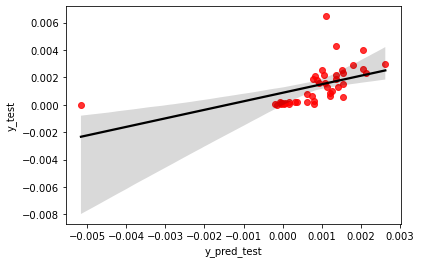

In [51]:
result=pd.DataFrame({"y_test":y_test,"y_pred_test":y_pred_test})

sns.regplot(x='y_pred_test',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})